In [1]:
import numpy as np
#import seaborn as sns
#sns.set()
#sns.set(font_scale=1.)
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from scipy import stats
from scipy.signal import find_peaks, hilbert, windows, blackman
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares

from itertools import product
from tools import HubbardModel as fhmodel, InitializeArchive

from collections import Counter
from itertools import product
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import glob
import os

from datetime import datetime

threads = 1
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
"""Laser Pulse parameters. These should remain constant across fields (with the exception of a)"""
field = 32.9  # field angular frequency THz
F0 = 4.5  # Field amplitude MV/cm
a_target = 4   # Lattice constant Angstroms

"""Parameters for a target or reference field"""
# Hubbard model
L_Target = 10             # system size
N_up_target = L_Target // 2 + L_Target % 2   # number of fermions with spin up
N_down_target = L_Target // 2           # number of fermions with spin down
N_target = N_up_target + N_down_target  # number of particles
t0_target = 0.52       # hopping strength
U_target = 0.0 * t0_target    # interaction strength
pbc = True

# Parameters for evolving the system
cycles = 10     # time in cycles of field frequency
n_steps_target = 10000  # Number of steps for time resolution

# Bundle parameters to pass to Hubbard Model class for unit conversion
tgt_params = dict(nx=L_Target, hopping=t0_target, interaction=U_target, n_up=N_up_target, n_down=N_down_target,
                  angular_frequency=field, lattice_constant=a_target, field_amplitude=F0, chem_potential=0,
                  cycles=cycles, n_steps=n_steps_target, ny=0, soc=0, gamma=0)

# Convert units using built-in functions
tgt = fhmodel(**tgt_params)
times_target, dt_target = np.linspace(0.0, tgt.stop, num=n_steps_target, endpoint=True, retstep=True)

"""Parameters for the tracking system"""
# Hubbard model
L = L_Target                # number of sites should be the same as the target field
N_up = N_up_target          # number of fermions with spin up should be same as target field
N_down = N_down_target      # number of fermions with spin down should be same as target field
N = N_up + N_down           # number of particles (should be same as target field)
t0 = t0_target              # hopping strength, (Usually same as target field)
U = 0.025 * t0                # interaction strength

# Scaling terms
a_scaling = 1               # Used if you need to scale the lattice constant
j_scaling = 1               # Used if you are scaling the current up instead of the lattice constant
a = a_target * a_scaling    # sets the lattice constant for the current system
n_steps = 4000

track_params = dict(nx=L, hopping=t0, interaction=U, n_up=N_up, n_down=N_down, angular_frequency=field,
                    lattice_constant=a, field_amplitude=F0, chem_potential=0, cycles=cycles, n_steps=n_steps,
                    ny=0, soc=0, gamma=0, tracking=True, int_track=U_target, lat_track=a_target)
track = fhmodel(**track_params)
# Timing parameters must remain the same for both systems
start = 0.0
stop = track.stop
times, dt = np.linspace(start, stop, num=n_steps, endpoint=True, retstep=True)

Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396
Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396


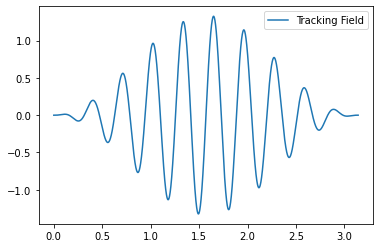

In [3]:
########################################################################################################################
# Load the Target system:
# 0 for a field and Target current generated by Generate_TargetFieldExpectations.py
# 1 for a Tracked field generated by Generate_TrackedFieldExpectations.py
# 2 for a Superoscillating field generated by this file
# 3 for Importing anything else or for testing
########################################################################################################################
"""Declare the simulation type you wish to track to using the above as reference"""
sim_type_to_be_loaded = 1

# Build out the directory
loading_lib = InitializeArchive(directory_number=sim_type_to_be_loaded).get_dir()
load_path = loading_lib['data path']
loadfile = load_path + loading_lib['tag'] + track.tag + '.npz'

expectations = dict(np.load(loadfile))
current = np.real(expectations['current'])
tracking_phi = np.real(expectations['phi'])
t = expectations['times']
pi_times = np.linspace(0.0, np.pi, n_steps)

# Interpolate the current and field to ensure consistency with time scale
current_interp = UnivariateSpline(pi_times, current, k=3, s=0)
phi_interp = UnivariateSpline(pi_times, tracking_phi, k=3, s=0)


# Plot the original field and the tracking field to verify both are loaded
plt.plot(pi_times, tracking_phi, label='Tracking Field')
plt.legend()
plt.show()

In [15]:
########################################
#
# Define single pulse function
#
########################################


def Phi(current_time, f, delay=0, stretch=1):
    """
    Modifiable version of the transform limited pulse
    :param current_time: time
    :param f: frequency, only allow up to max_freq determined in the tfl_pulse cell
    :param delay: time delay
    """
    return np.sin(current_time / stretch) ** 2 * np.sin(f * (current_time - delay))

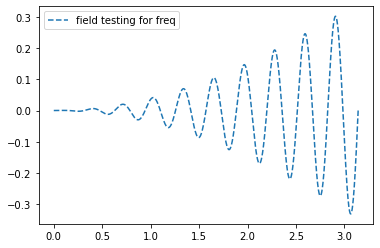

In [22]:
####################################################################################
#
# Verify the maximum frequency by comparing it to the frequency of the initial field
#
####################################################################################
def tfl_pulse(current_time):
    """
    Defines the transform limited pulse for an individual time step
    :param current_time: Current time
    :return: transform limited pulse (current time)
    """
    return (tgt.a * tgt.F0 / tgt.omega) * (np.sin(tgt.omega * current_time / (2. * cycles)) ** 2.) * np.sin(
        tgt.omega * current_time)
max_freq=20
component_field = tfl_pulse(t)
component_field /= component_field.max()
testing_field = Phi(pi_times, max_freq, delay=0, stretch=5)
#testing_field /= testing_field.max()
#plt.plot(pi_times, component_field, label='Transform Limited Pulse')
plt.plot(pi_times, testing_field, '--', label='field testing for freq')
plt.legend()
plt.show()

In [67]:
##############################################
#
# Get the initial guesses for the optimization
#
##############################################

# Number of pulses
n = 400

# Determine the error tolerance
eps = 1e-4

# New array for time
time = pi_times[:, np.newaxis]
# Set
workers = 32
# Number of initial guesses per thread
init_guess_n = workers # * 3

# Create the array of variables for the initial guess
initial_guess = np.hstack([
    # Frequency
    np.random.uniform(0, max_freq, (init_guess_n, n)),
    # Delay
    np.random.uniform(0, np.pi, (init_guess_n, n)),
    # Amplitudes
    np.random.uniform(-5, 5, (init_guess_n, n))
])

print('Number of Pulses: {}'.format(n))
#initial_guess = np.array([20, 0, 0, 1])

print('Length of x: ' + str(len(initial_guess)))

# Define the constraints
freq_lims = (0, max_freq)  # Frequency constrained to be less or equal to original field
delay_lims = (0, np.pi)           # Time delay constrained to be positive
ampl_lims = (None, None)      # No constraints for amplitude


# Create the array of bounds for the best fit minimization
bnds = np.concatenate([
    # frequency lims
    np.full((n, 2), freq_lims),
    # Frequency initial guess
    np.full((n, 2), delay_lims),
    # Amplitude limits
    np.full((n, 2), ampl_lims)
])



Number of Pulses: 400
Length of x: 32


In [68]:
#######################################
#
# Define Functions for fitting
#
#######################################


def unpack(x):
    # Ensure that the array is equally divisible by number of parameters
    length, res = divmod(len(x), 3)
    assert res == 0
    
    frequencies = x[:length]
    delays = x[(length):(2 * length)]
    amplitudes = x[(2 * length):(3 * length)]
    
    return frequencies, delays, amplitudes


def phi_func(x):
    freq, delay, amplitude = unpack(x)
    return Phi(time, freq, delay) @ amplitude


def obj(x):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z) - tracking_phi) ** 2, 
        x,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x



In [69]:
#########################################################################
#
# Fitting the fields by optimizing the frequencies, delays, and streches
# Uses Parallel computing to find best results
#
#########################################################################

if __name__ == '__main__':
    # with Pool(processes=workers) as pool:
    with Pool() as pool: 
        result = pool.map(obj, initial_guess)

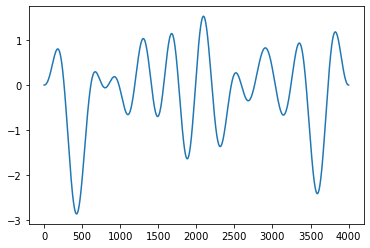

In [70]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result.sort(key=lambda _: _[0])
opt_vals = result[0][1]
best_fit = phi_func(opt_vals)

plt.plot(best_fit)
#plt.plot(tracking_phi, label='Target Tracking Field')
#plt.legend()
plt.show()

In [71]:
#######################################################
#
# Take the optimized parameters and get best amplitudes
#
#######################################################
opt_freqs, opt_dels, first_round_amps = unpack(opt_vals)
print(best_fit.shape)
print(tracking_phi.shape)
opt_amp = lstsq(Phi(time, opt_freqs, opt_dels), tracking_phi)[0]

(4000,)
(4000,)


Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396


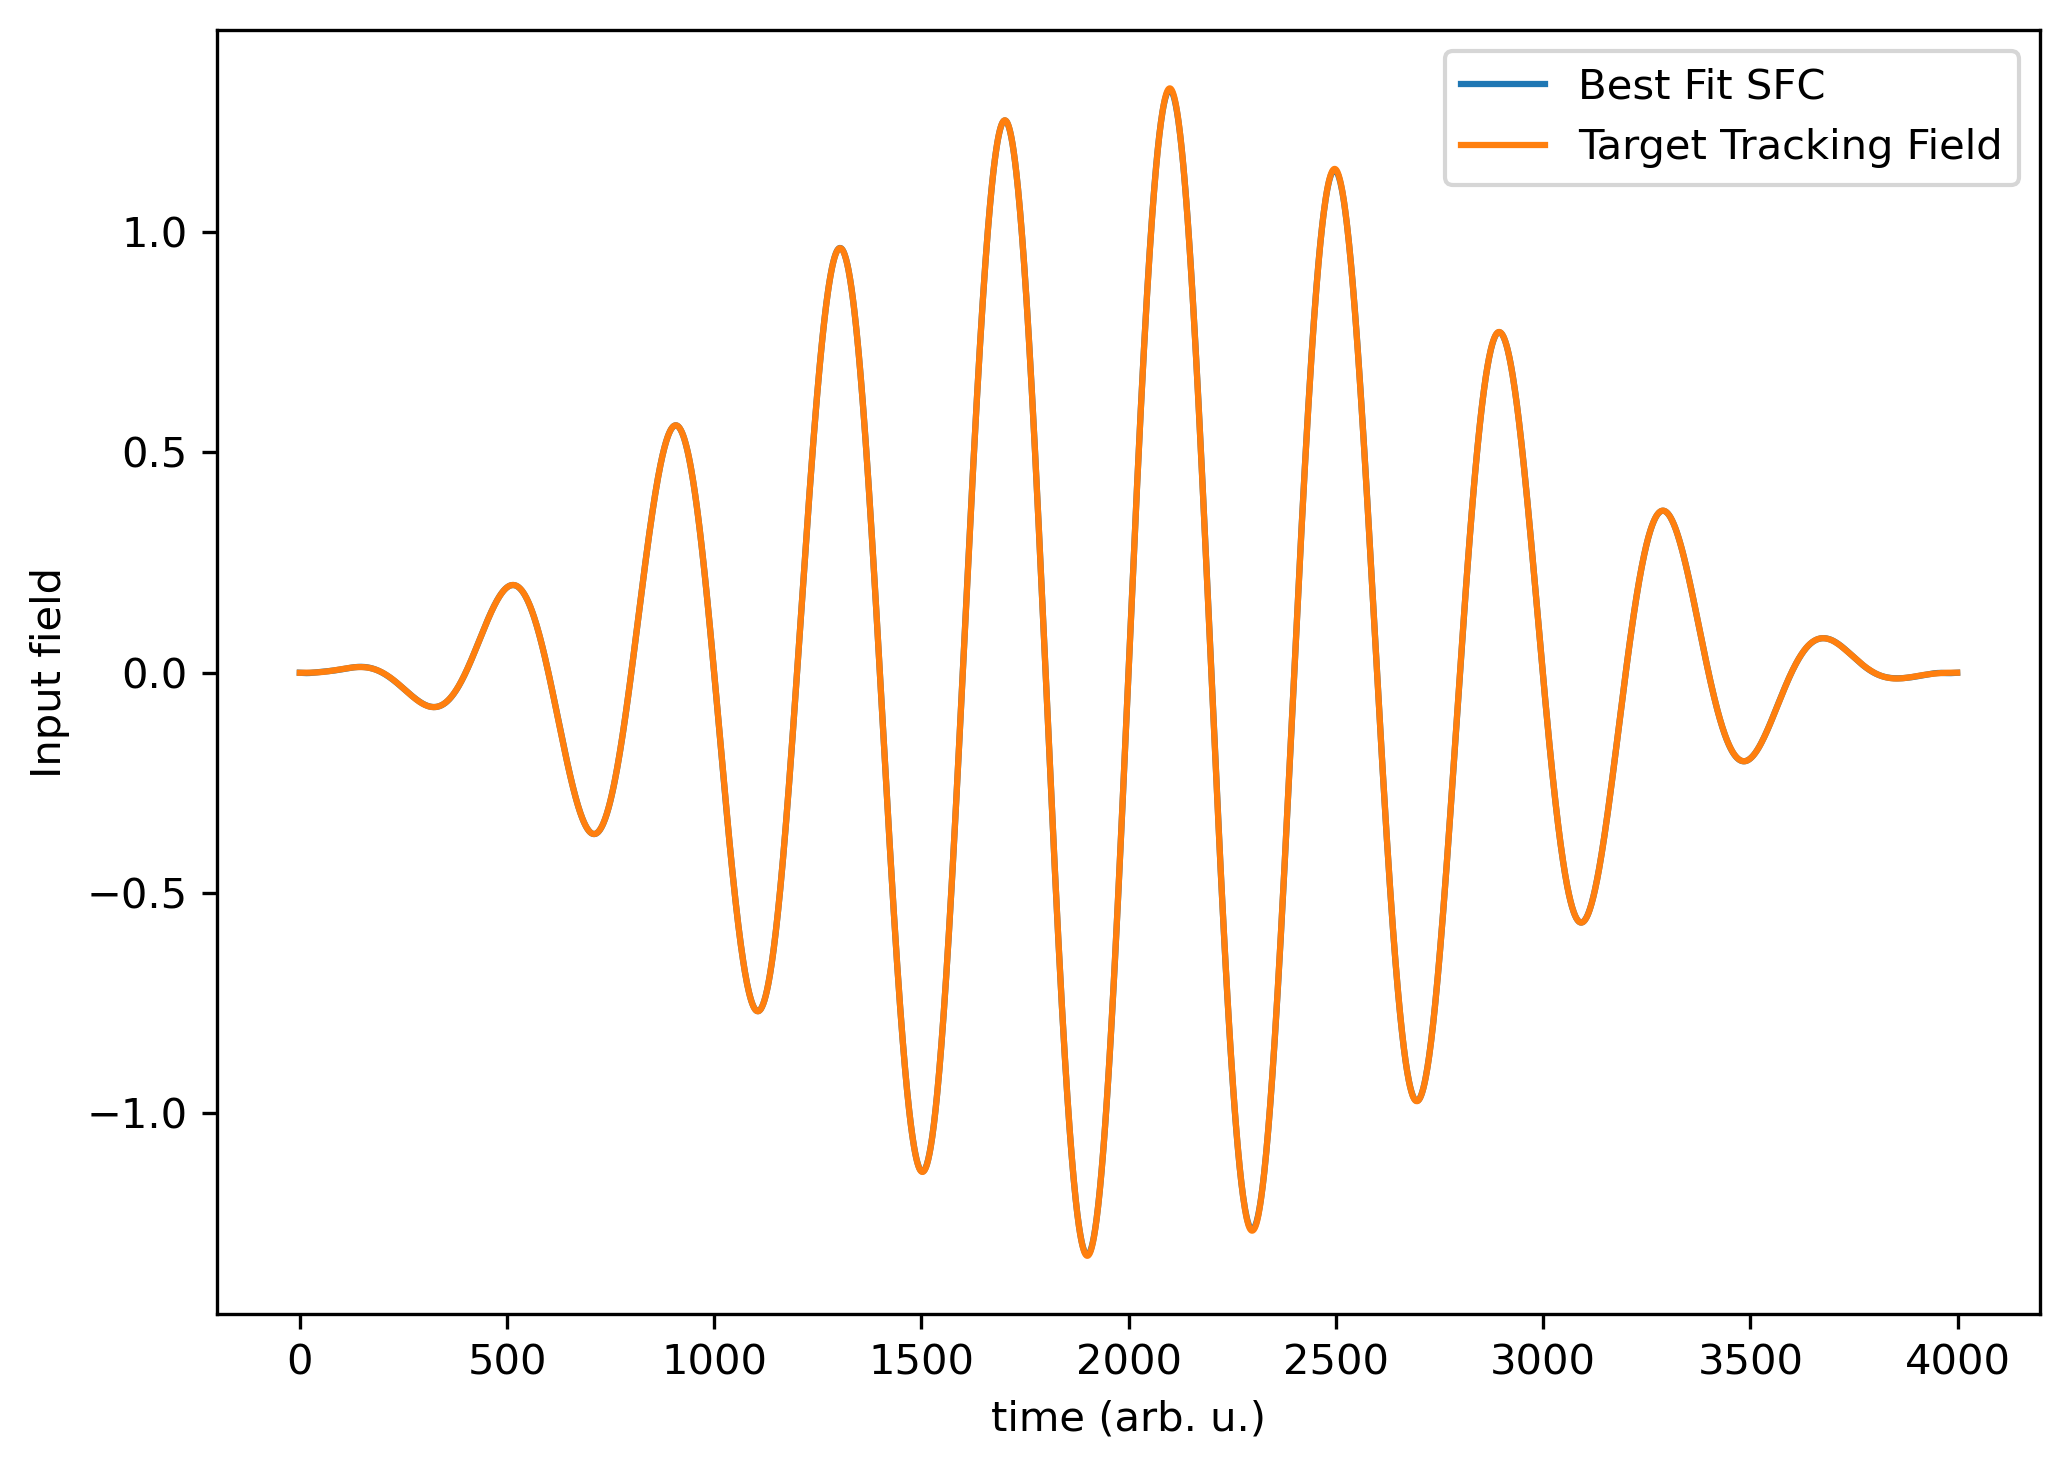

Minimization success: False


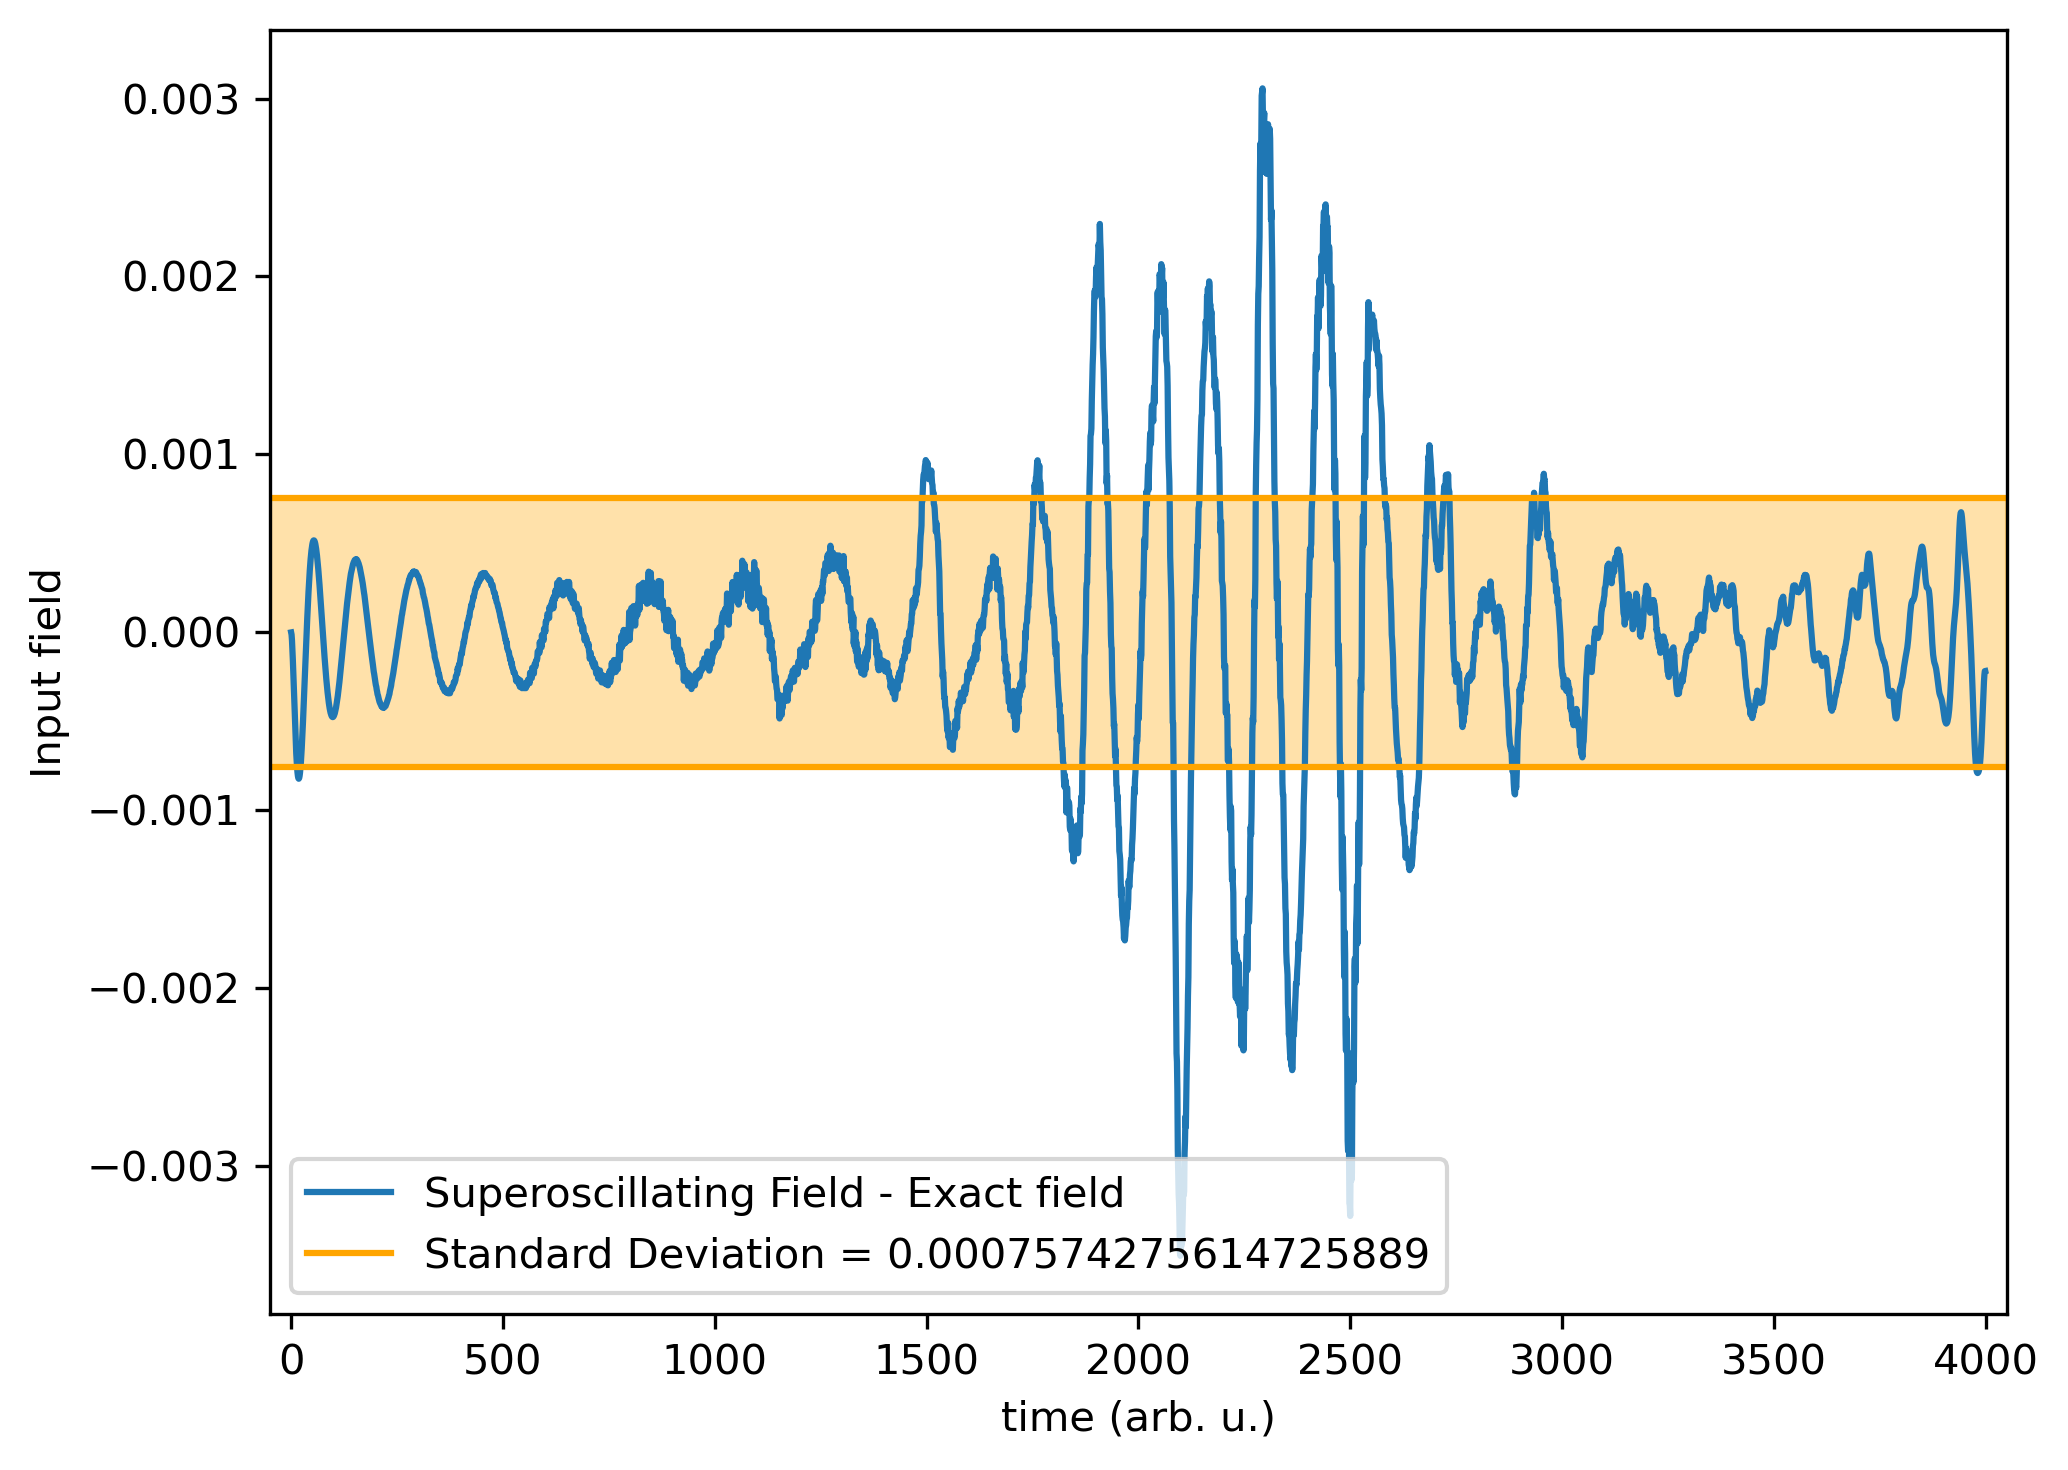

In [72]:
##############################################
#
# Get the best result for the initial guesses
#
##############################################

result_fit = np.array(Phi(time, opt_freqs, opt_dels)) @ opt_amp
scf_params = dict(nx=L, hopping=t0, interaction=U, n_up=N_up, n_down=N_down, angular_frequency=field,
                    lattice_constant=a, field_amplitude=F0, chem_potential=0, cycles=cycles, n_steps=n_steps,
                    ny=0, soc=0, gamma=0, tracking=True, int_track=U_target, lat_track=a_target, scf=True, pulses=n)

scf = fhmodel(**scf_params)
directory = InitializeArchive(directory_number=2)

lib = directory.get_dir()
data_path = lib['data path']
plot_path = lib['plots path']
plot_name = lib['plot name']

scf_tag = lib['tag'] + scf.tag

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(result_fit, label='Best Fit SFC')
plt.plot(tracking_phi, label='Target Tracking Field')
plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig(plot_path + plot_name + scf_tag + ".pdf")
plt.show()

field_diff = result_fit - tracking_phi
avg_diff = sum(field_diff) / len(field_diff)
std_dev_array = []
for i in range(0,len(field_diff)):
    std_dev_array.append((field_diff[i] + avg_diff) ** 2)
std_dev = np.sqrt(sum(std_dev_array)/len(field_diff))

success = std_dev <= eps
print('Minimization success: ' + str(success))

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(std_dev))
plt.axhline(y=-std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(field_diff)+50], -std_dev, std_dev, facecolor="orange",
    color='orange', alpha=0.333)

plt.legend()
plt.xlim(-50,len(field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig(plot_path + plot_name + scf_tag + ".pdf")
plt.show()

In [73]:
######################################
#
# Save the Unreaped Field
#
######################################

filetag = scf_tag
out = data_path + filetag + '.npz'
BestFitSCF = np.array(Phi(time, opt_freqs, opt_dels)) @ opt_amp
np.savez(out, phi=BestFitSCF, x=opt_amp)
print(out)

./Data/BestFit_SCF/SCFparams_10sites-0,013TrackedTo0,000U-0,52t0-4,5F0-4TrackedTo4a-10cycles-4000steps-400pulses.npz


In [13]:
#################################################################
#
# Cell inserted for readability, Stop here if you are not reaping
#
#################################################################

print('Main calculations completed and results are saved.') 
print('Proceed to lower cells to begin reaping pulses.')

Main calculations completed and results are saved.
Proceed to lower cells to begin reaping pulses.


In [14]:
########################################################################
#
# Define the reaping function
#
########################################################################


def reaping(amplitudes, frequencies, delays, reap_lim):
    """
    Reaps a set amount of top results from an amplitude array 
    and keeps the corresponding frequencies, dilations, and delays.
    """
    pointers = sorted(range(len(amplitudes)), key=lambda x: np.abs(opt_amp[x]))[-reap_lim:]
    new_amplitudes = list(map(
        lambda x: amplitudes[x],
        pointers))
    new_frequencies = list(map(
        lambda x: frequencies[x],
        pointers))
    new_delays = list(map(
        lambda x: delays[x], 
        pointers))
    new_phi_parameters = np.concatenate(
        (new_frequencies, new_delays, new_amplitudes), axis=None)
    return new_phi_parameters


In [29]:
###################################
#
# Get the new guesses and reiterate
#
###################################

percent_to_reap = 0.50
new_n = int(percent_to_reap * len(opt_amp))
"""number_to_reap = 1
new_n = int(len(opt_amp) - number_to_reap)"""

new_phi_guesses = reaping(opt_amp, opt_freqs, opt_dels, new_n)
print(len(new_phi_guesses))
print(new_n)

bnds = np.concatenate([
    # frequency lims
    np.full((new_n, 2), freq_lims),
    # delay limits
    np.full((new_n, 2), delay_lims),
    # Amplitude limits
    np.full((new_n, 2), ampl_lims)
])

reaped_result = obj(new_phi_guesses)
new_vals = reaped_result[1]
new_best_fit = phi_func(new_vals)
new_freqs, new_dels, retried_amps = unpack(new_vals)
new_amp = lstsq(Phi(time, new_freqs, new_dels), tracking_phi)[0]

1200
400


Number of pulses after reaping: 400
Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396


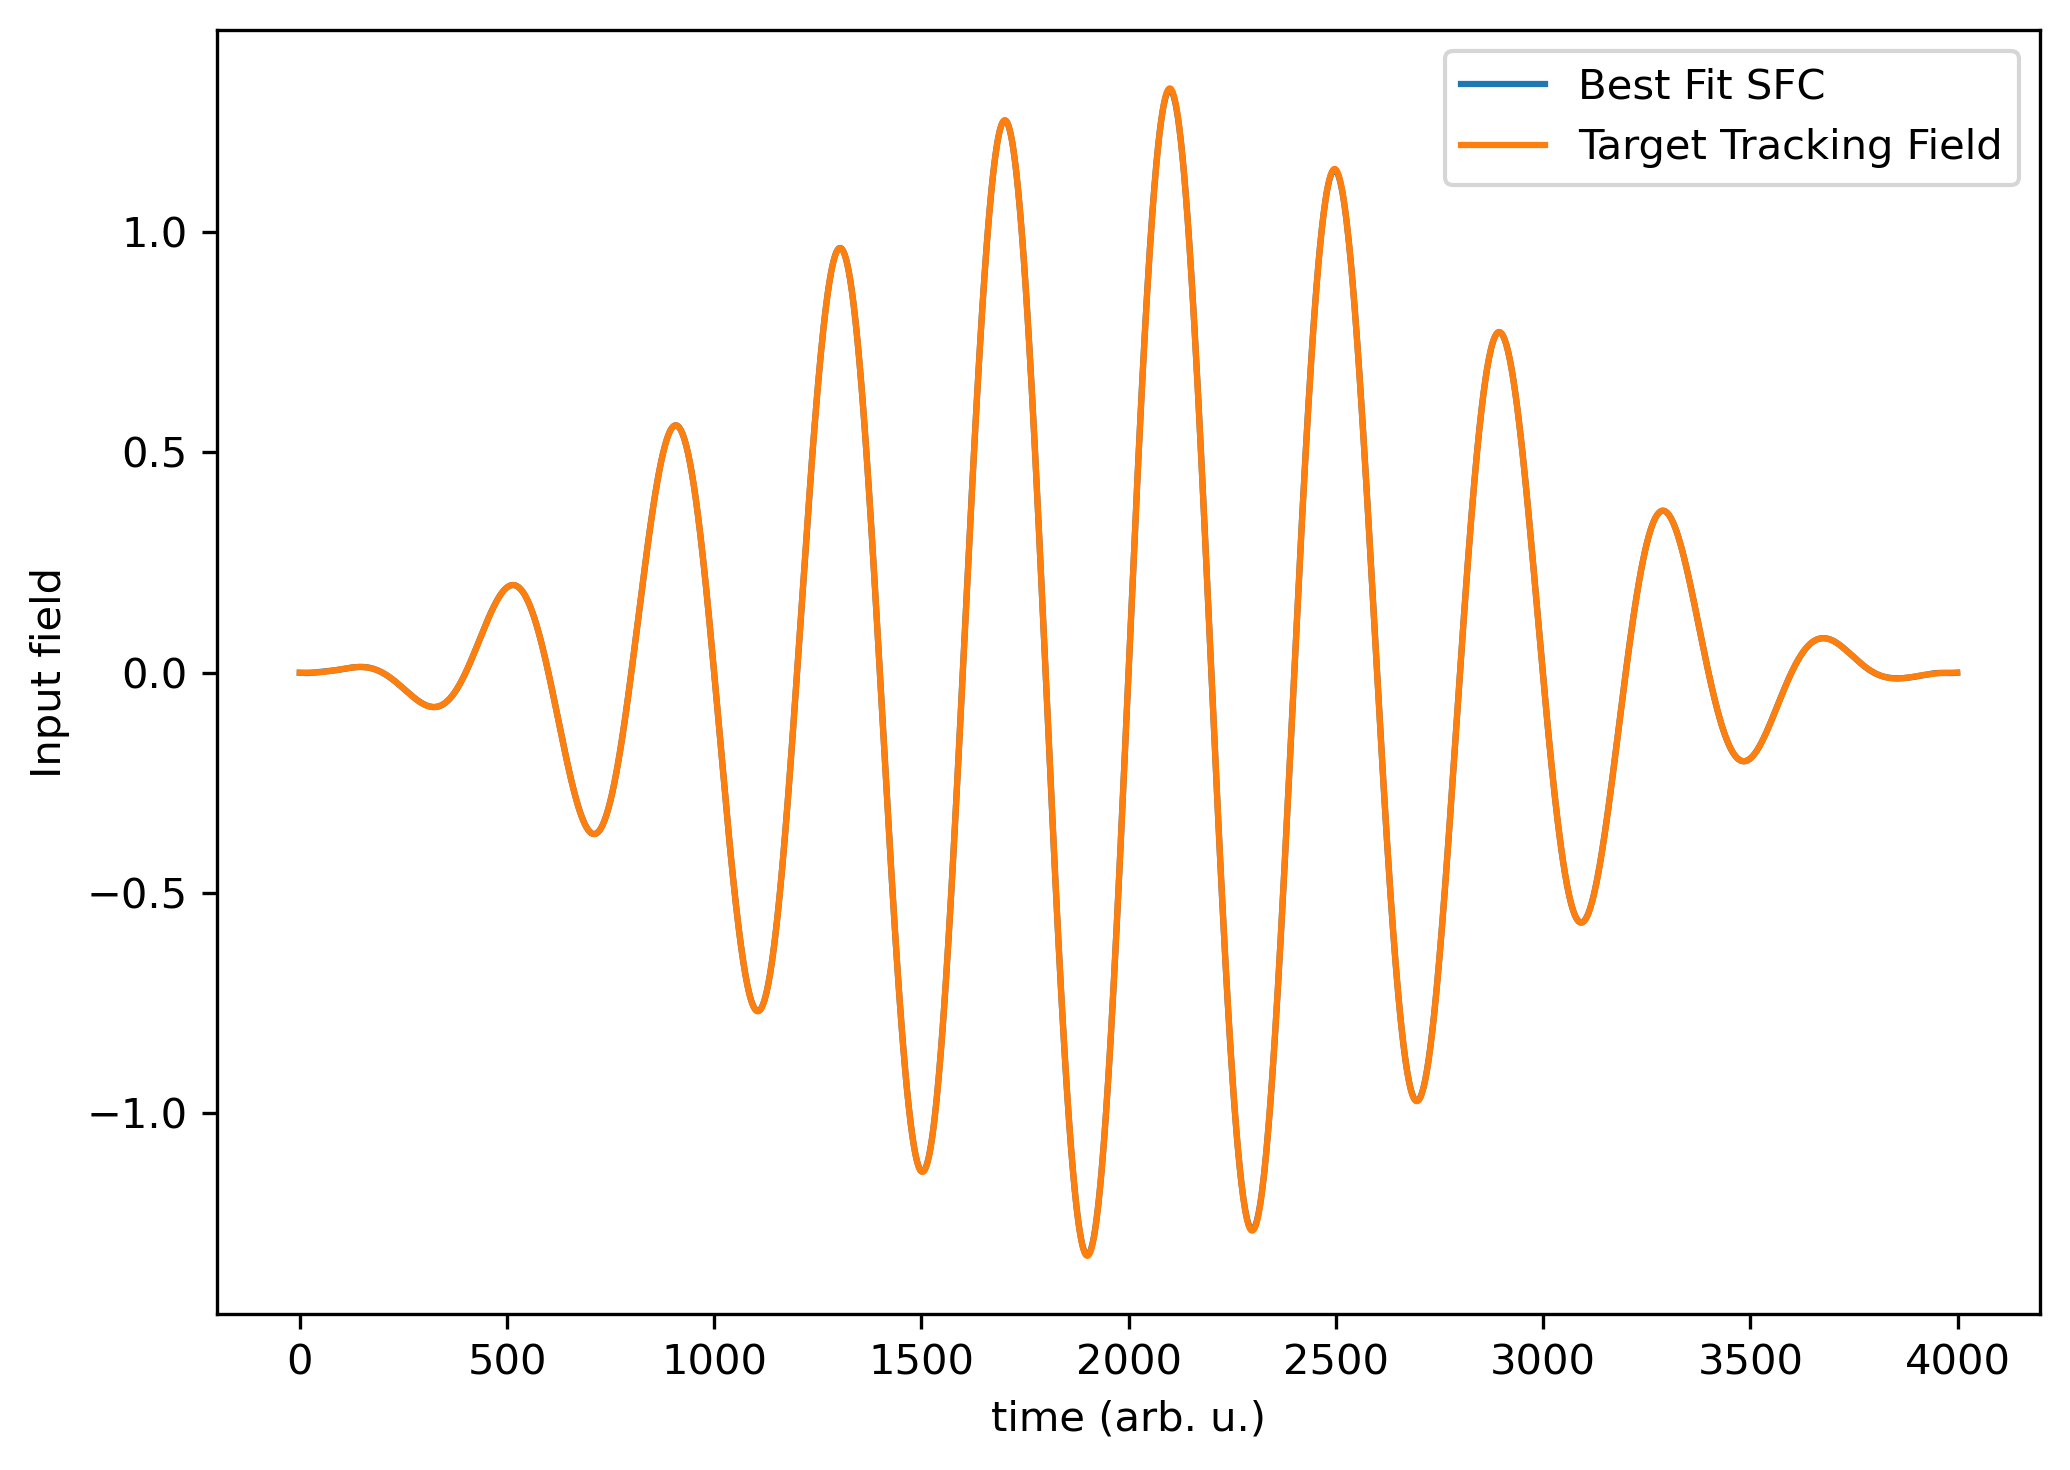

Minimization success: False


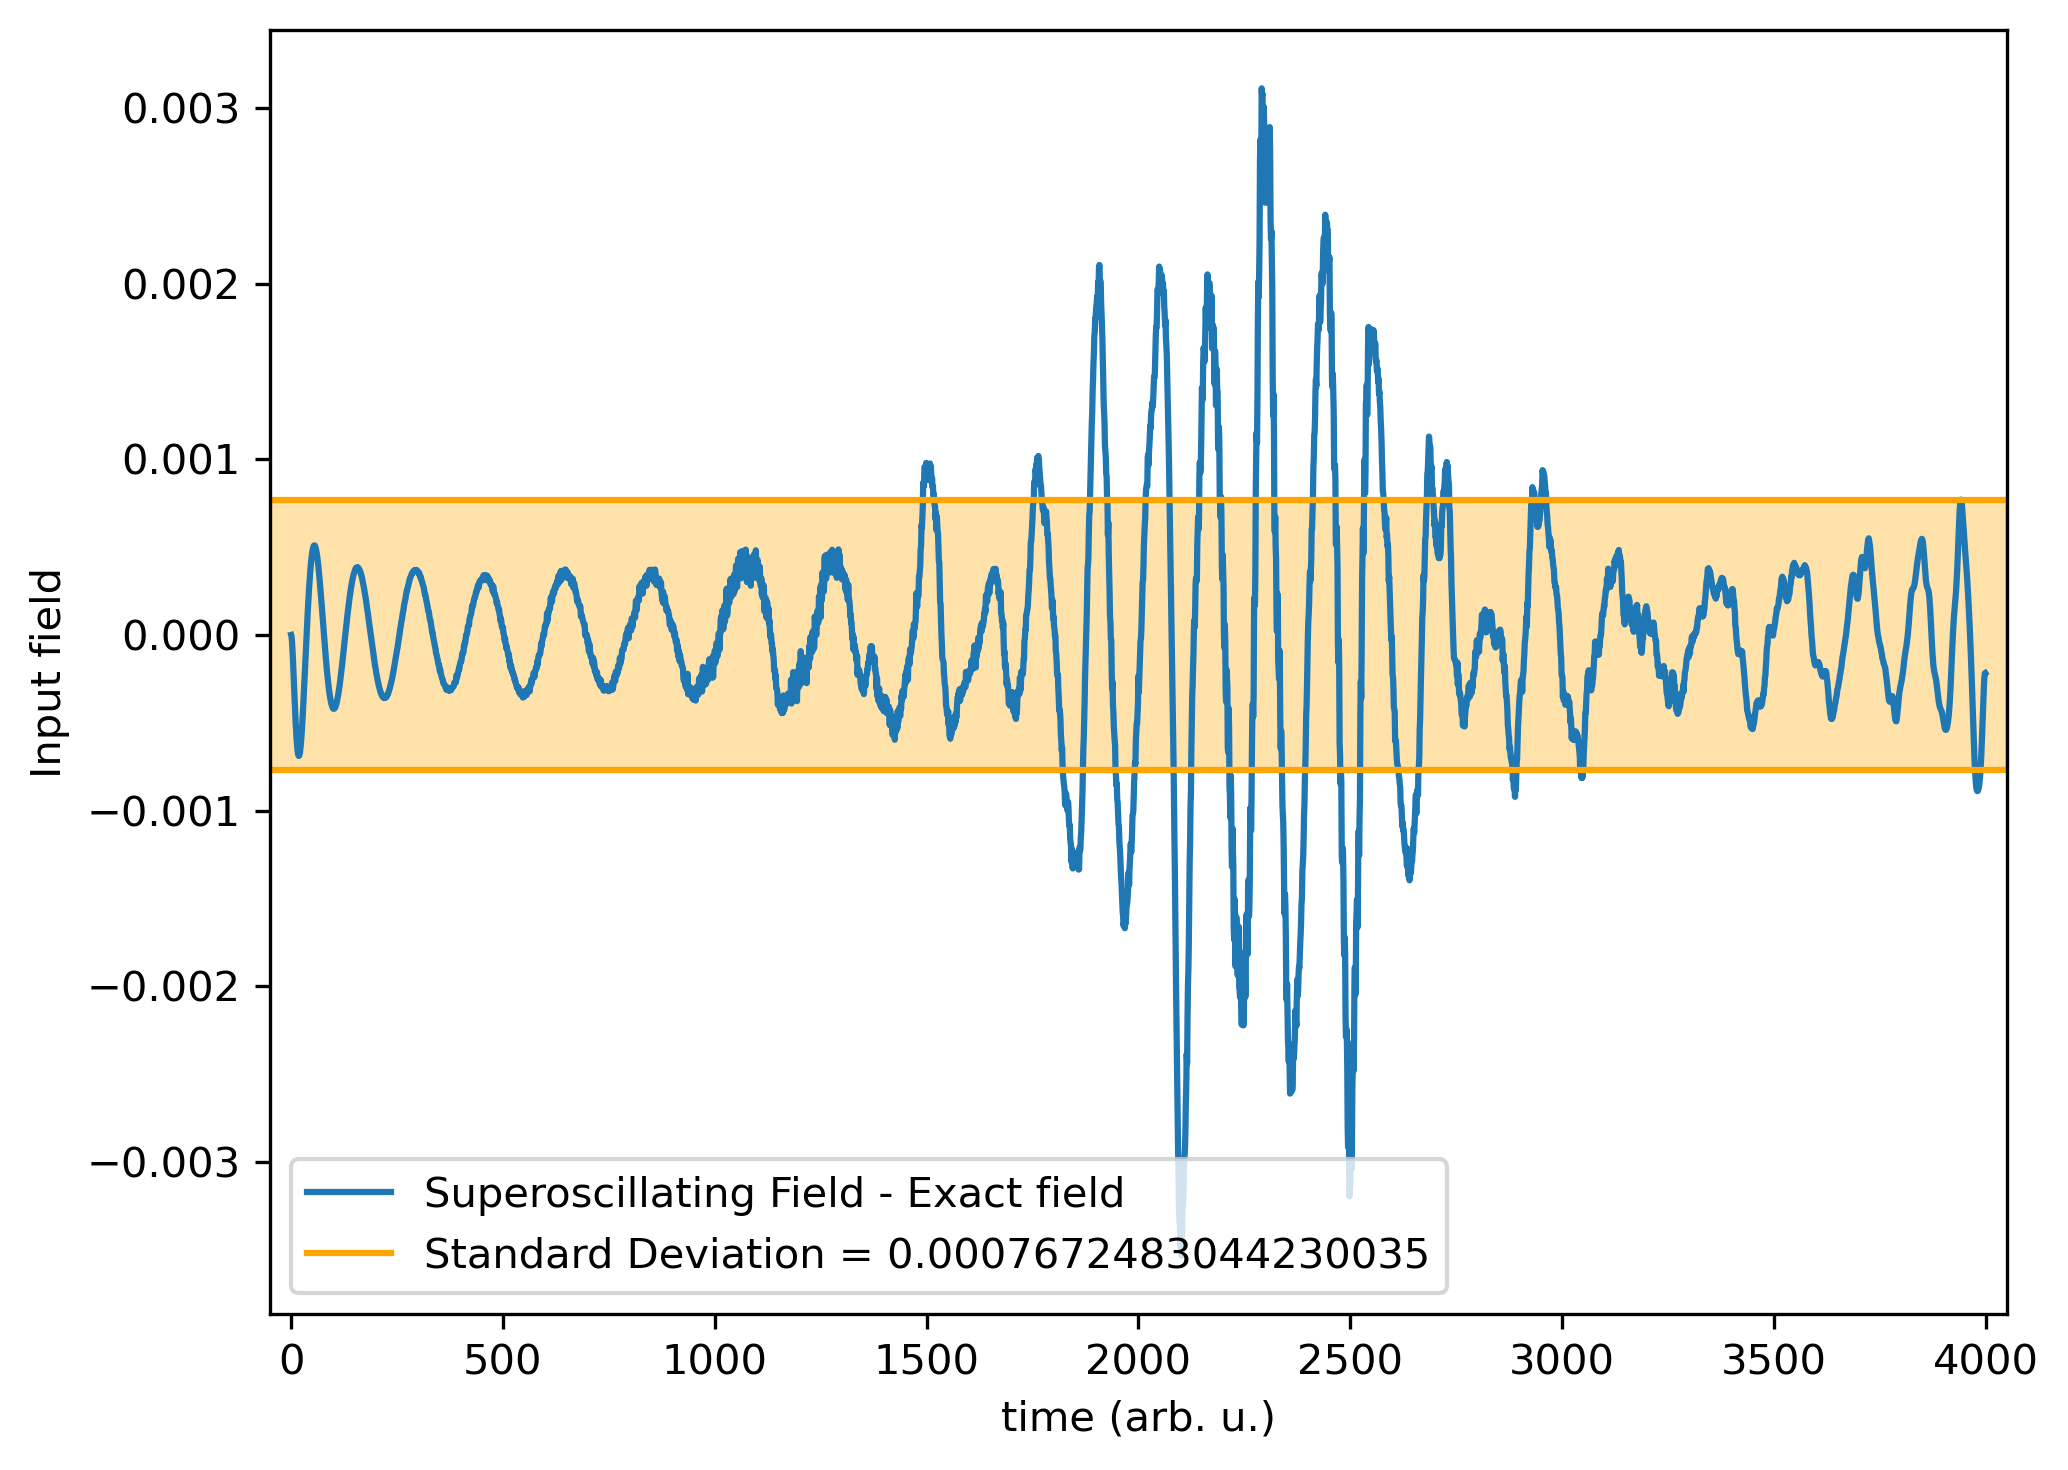

In [30]:
##############################################
#
# Get the best result for the reaped guesses
#
##############################################

new_fit = np.array(Phi(time, new_freqs, new_dels)) @ new_amp
scf_params_reaped = scf_params
scf_params_reaped['pulses']=new_n
scf_params_reaped['reaping']=True
print('Number of pulses after reaping: {}'.format(new_n))
scf_tag_reaped = lib['tag'] + fhmodel(**scf_params_reaped).tag

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(new_fit, label='Best Fit SFC')
plt.plot(tracking_phi, label='Target Tracking Field')
plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig(plot_path + plot_name + scf_tag_reaped + ".pdf")
plt.show()

new_field_diff = new_fit - tracking_phi
new_avg_diff = sum(new_field_diff) / len(new_field_diff)
new_std_dev_array = []
new_std_dev_array.clear()
for i in range(0,len(new_field_diff)):
    new_std_dev_array.append((new_field_diff[i] + new_avg_diff) ** 2)
new_std_dev = np.sqrt(sum(new_std_dev_array)/len(new_field_diff))

success = new_std_dev <= eps
print('Minimization success: ' + str(success))

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(new_field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=new_std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(new_std_dev))
plt.axhline(y=-new_std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(new_field_diff)+50], -new_std_dev, new_std_dev, facecolor="orange",
            color='orange', alpha=0.333)

plt.legend()
plt.xlim(-50,len(new_field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig(plot_path + plot_name + scf_tag_reaped + ".pdf")
plt.show()

In [31]:
######################################
#
# Save the Reaped Field
#
######################################

filetag_reaped = scf_tag_reaped
reaped_out = data_path + filetag_reaped + '.npz'
ReapedFitSCF = np.array(Phi(time, new_freqs, new_dels)) @ new_amp
np.savez(reaped_out, phi=ReapedFitSCF, x=new_amp)
print(reaped_out)

./Data/BestFit_SCF/SCFparams_10sites-0,013TrackedTo0,000U-0,52t0-4,5F0-4TrackedTo4a-10cycles-4000steps-400reaped_pulses.npz


Number of pulses after reaping: 25
Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396


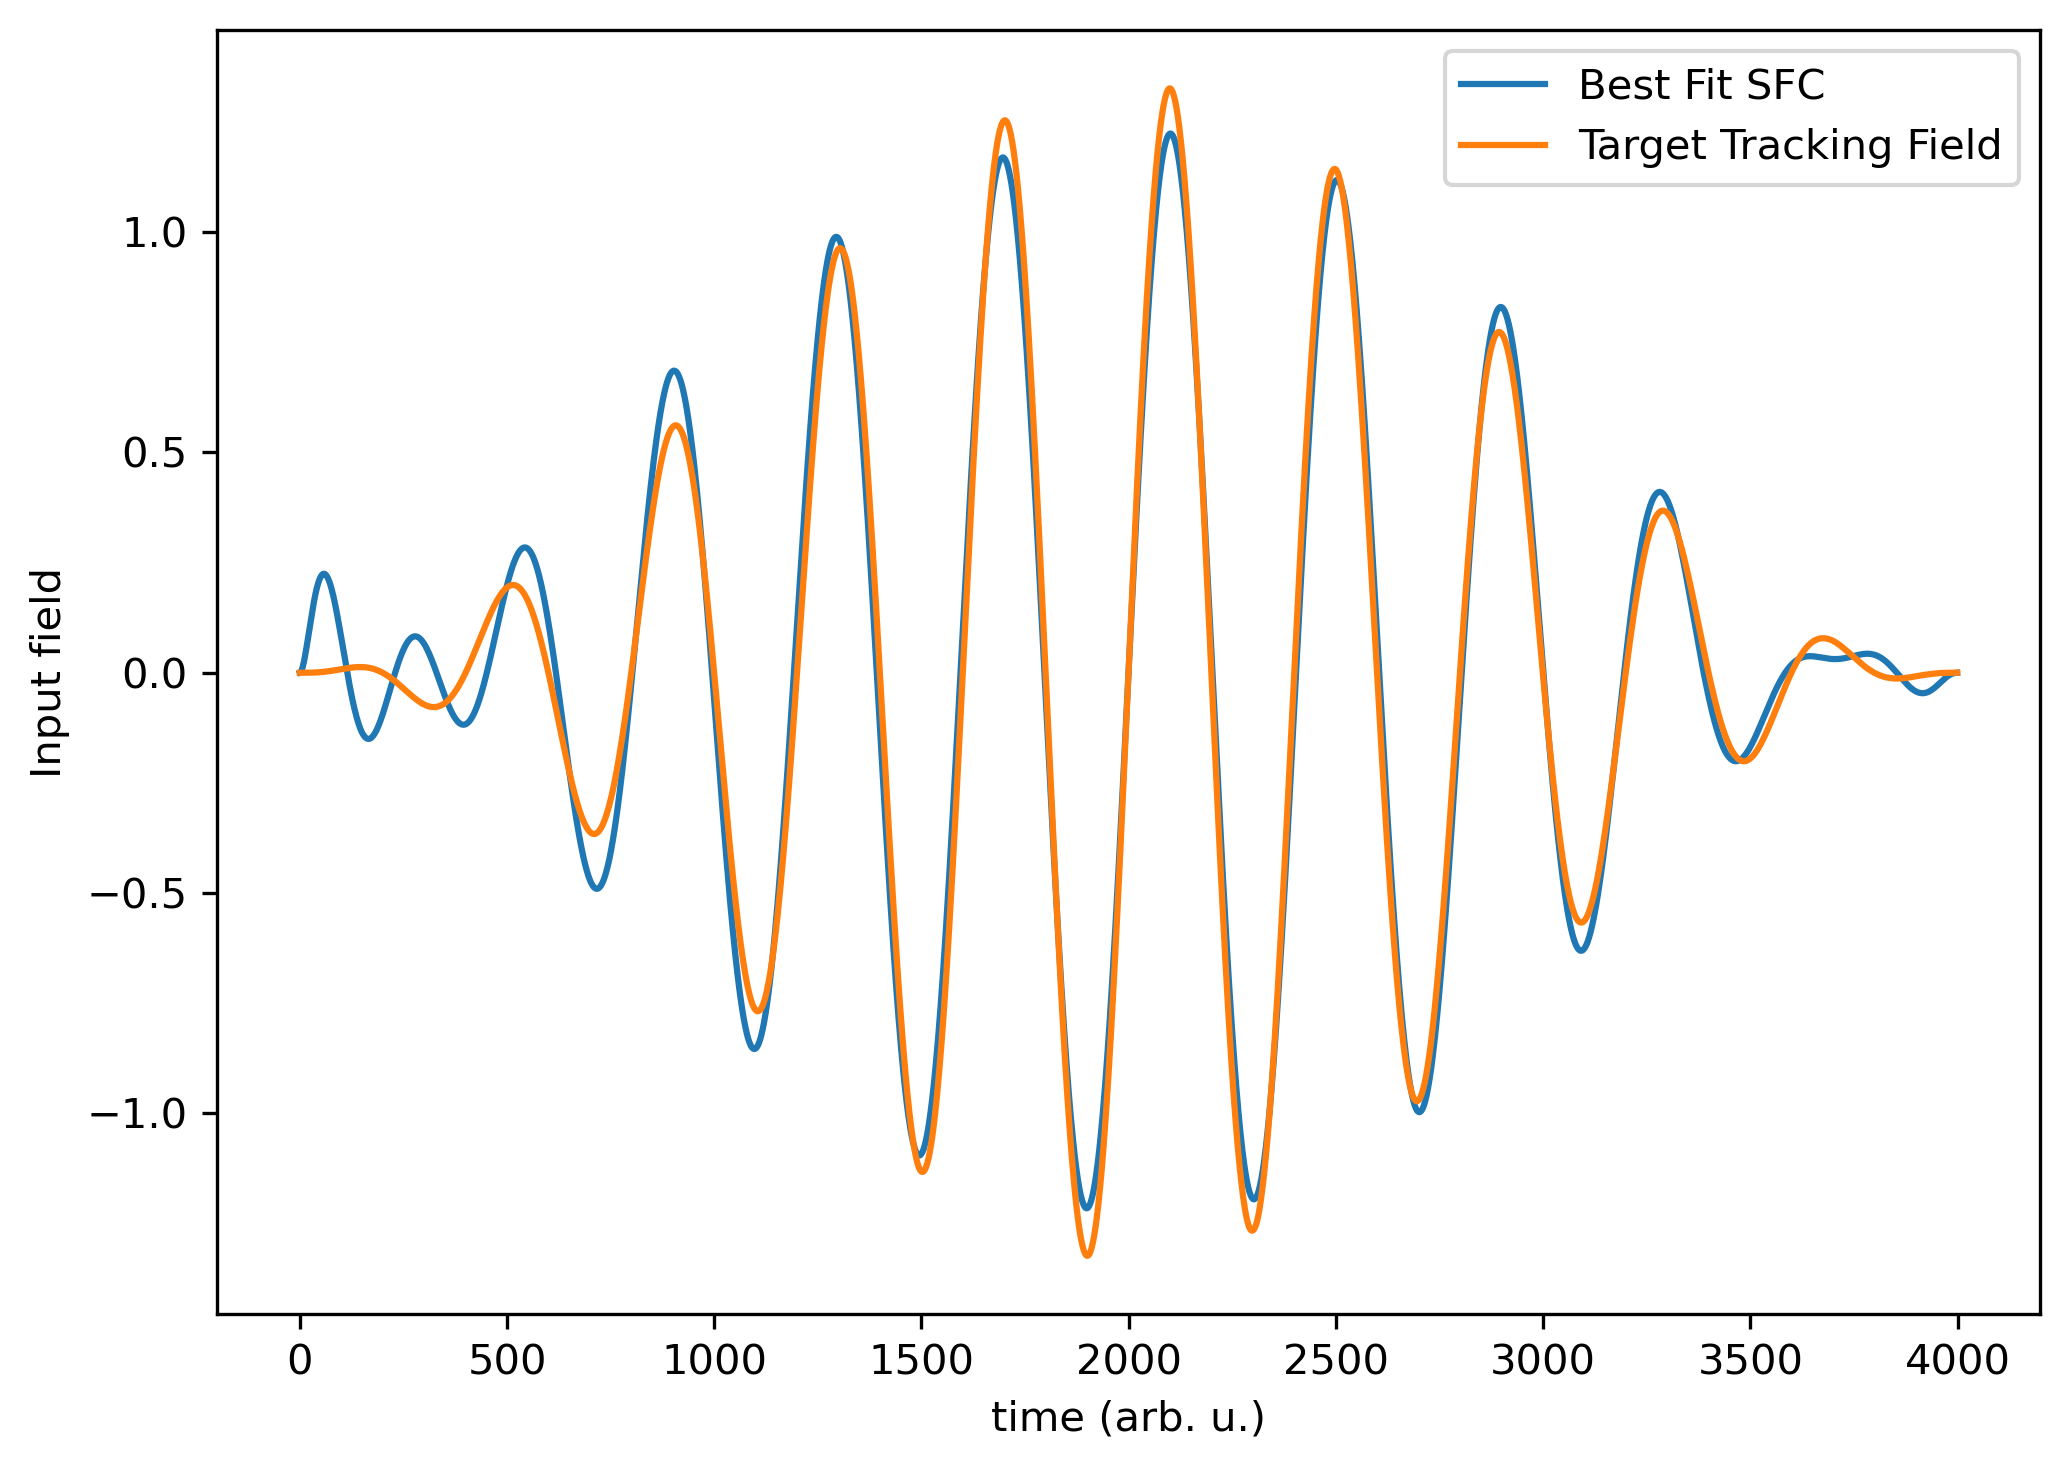

Minimization success: False


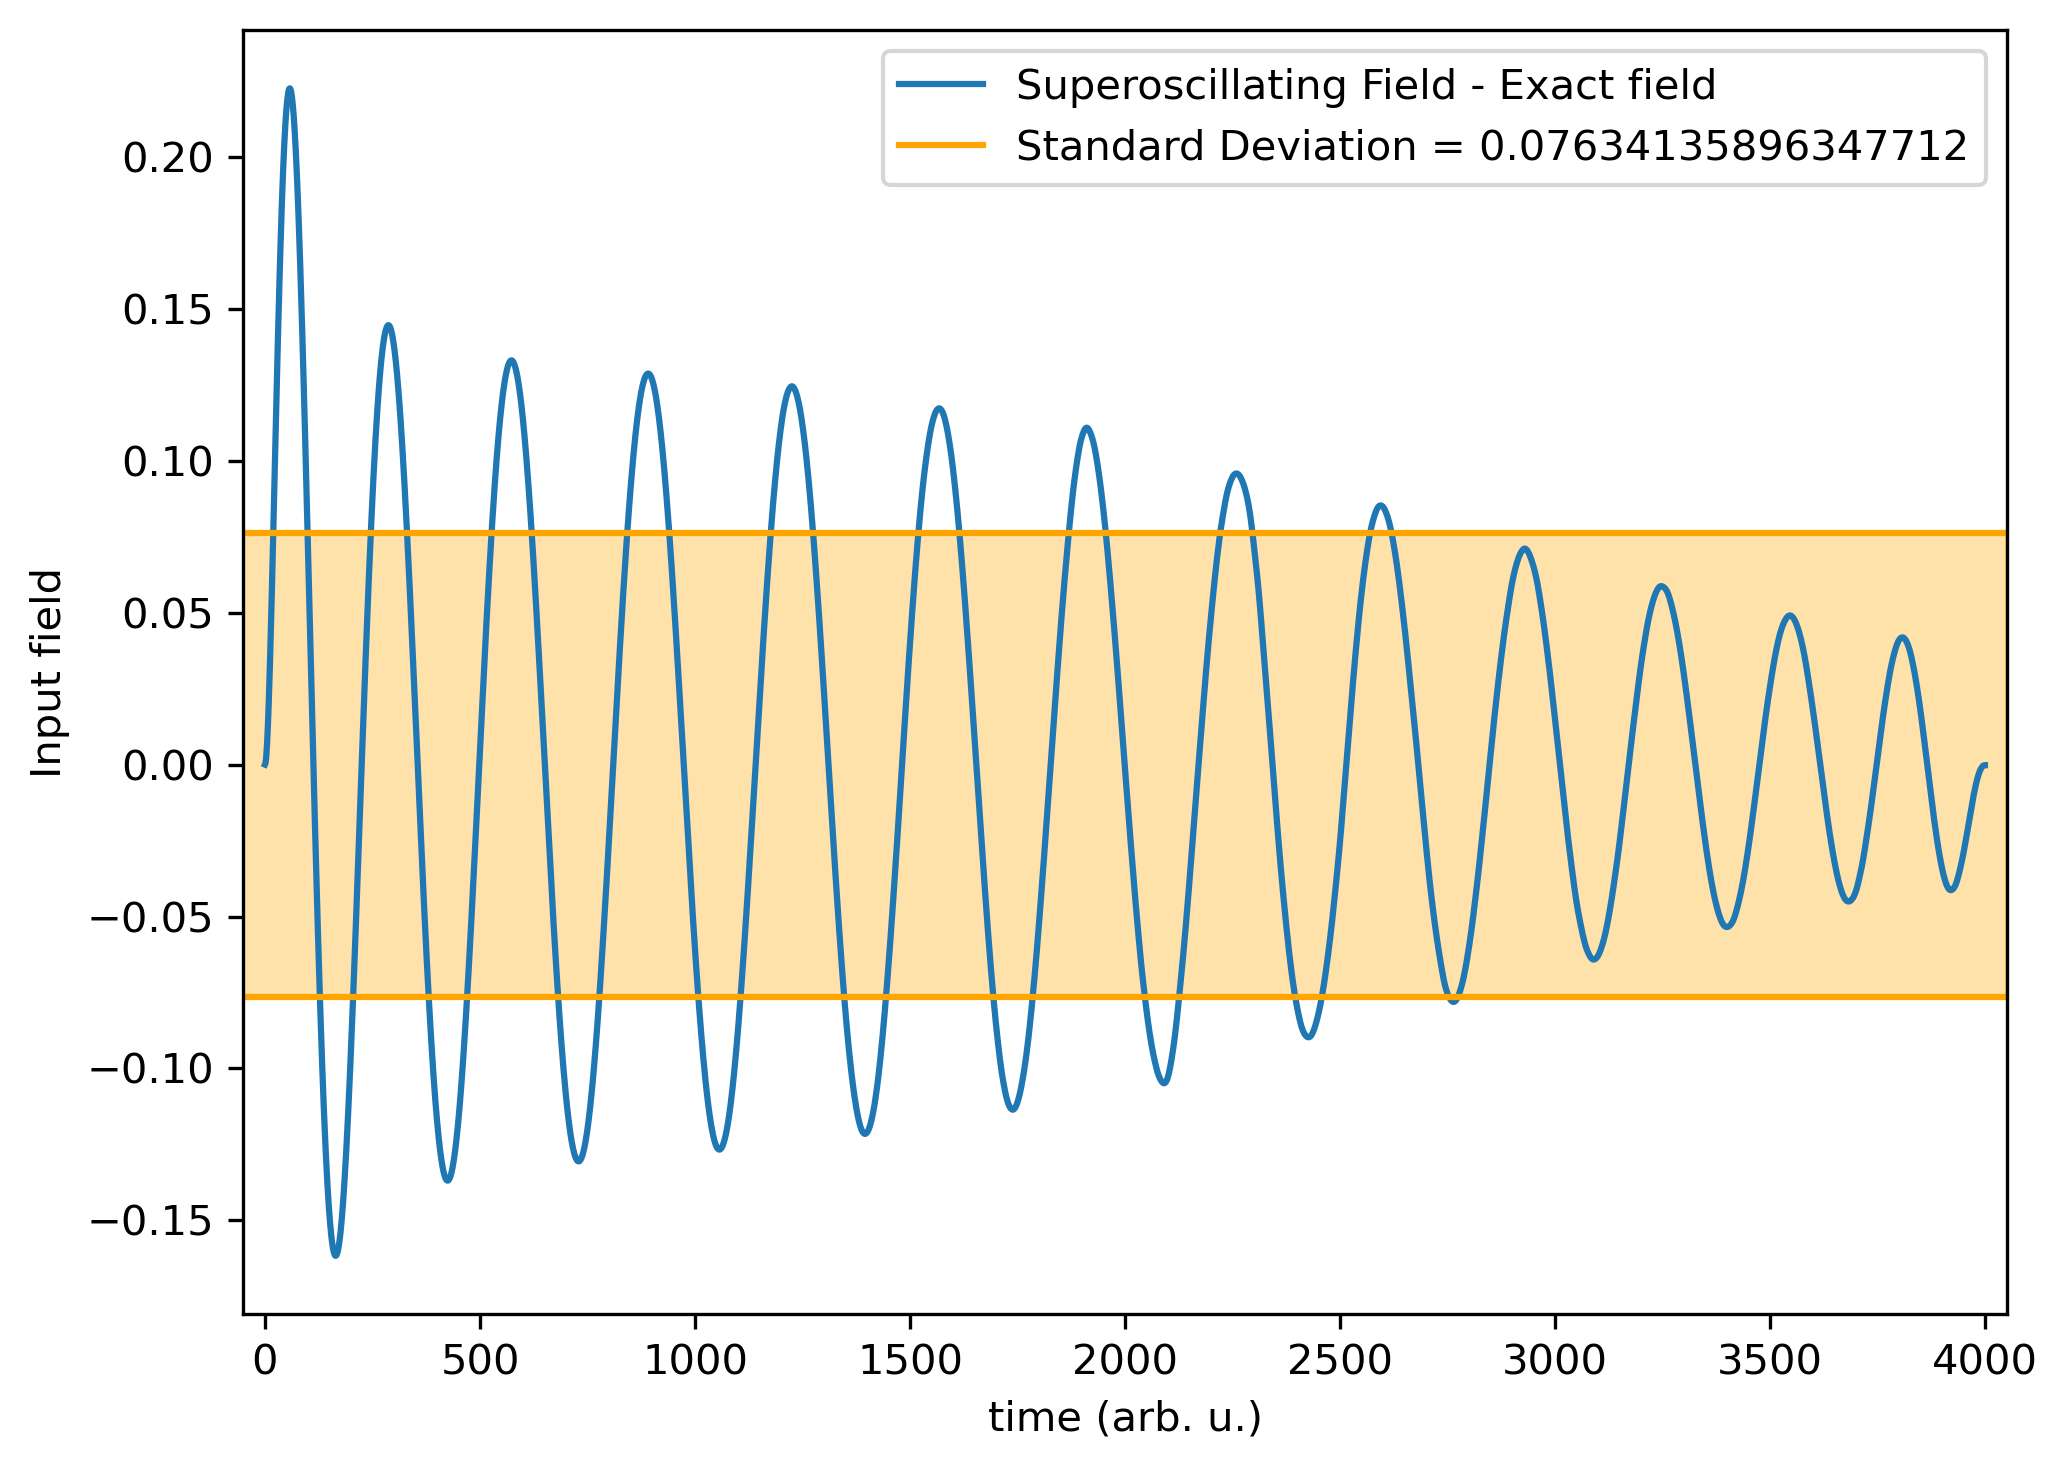

In [38]:
#############################################################
#
# Get the new guesses and reiterate (This cell can be looped)
#
#############################################################

percent_to_reap = 0.5
new_n = int(percent_to_reap * len(new_amp))
"""number_to_reap = 1
new_n = int(len(new_amp) - number_to_reap)"""
if new_n < 1:
    print('ATTENTION: Reaping is completed. Number of pulses = 1')
    new_n = 1
new_phi_guesses = reaping(new_amp, new_freqs, new_dels, new_n)
print('Number of pulses after reaping: {}'.format(new_n))
scf_params_reaped['pulses']=new_n
scf_tag_reaped = lib['tag'] +  fhmodel(**scf_params_reaped).tag

bnds = np.concatenate([
    # frequency lims
    np.full((new_n, 2), freq_lims),
    # delay limits
    np.full((new_n, 2), delay_lims),
    # Amplitude limits
    np.full((new_n, 2), ampl_lims)
])
reaped_result = obj(new_phi_guesses)
new_vals = reaped_result[1]
new_best_fit = phi_func(new_vals)
new_freqs, new_dels, retried_amps = unpack(new_vals)
new_amp = lstsq(Phi(time, new_freqs, new_dels), tracking_phi)[0]

################################################
#
# Get the best result for the new reaped guesses
#
################################################

new_fit = np.array(Phi(time, new_freqs, new_dels)) @ new_amp

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(new_fit, label='Best Fit SFC')
plt.plot(tracking_phi, label='Target Tracking Field')
plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig(plot_path + plot_name + scf_tag_reaped + ".pdf")
plt.show()

new_field_diff = new_fit - tracking_phi
new_avg_diff = sum(new_field_diff) / len(new_field_diff)
new_std_dev_array = []
new_std_dev_array.clear()
for i in range(0,len(new_field_diff)):
    new_std_dev_array.append((new_field_diff[i] + new_avg_diff) ** 2)
new_std_dev = np.sqrt(sum(new_std_dev_array)/len(new_field_diff))

success = new_std_dev <= eps
print('Minimization success: ' + str(success))

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(new_field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=new_std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(new_std_dev))
plt.axhline(y=-new_std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(new_field_diff)+50], -new_std_dev, new_std_dev, facecolor="orange",
            color='orange',
        alpha=0.333)

plt.legend()
plt.xlim(-50,len(new_field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig(plot_path + plot_name + scf_tag_reaped + ".pdf")
plt.show()

In [37]:
####################################################
#
# Save the Reaped Field (Duplicated for ease of use)
#
####################################################

filetag_reaped = scf_tag_reaped
reaped_out = data_path + filetag_reaped + '.npz'
ReapedFitSCF = np.array(Phi(time, new_freqs, new_dels)) @ new_amp
np.savez(reaped_out, phi=ReapedFitSCF, x=new_amp)
print(reaped_out)

./Data/BestFit_SCF/SCFparams_10sites-0,013TrackedTo0,000U-0,52t0-4,5F0-4TrackedTo4a-10cycles-4000steps-50reaped_pulses.npz
